# Weeks 5 and 6. Natural language processing

## Part 3. Sentiment analysis
In this notebook, you'll learn to:
* Scrape Twitter data using the API
* Conduct sentiment analysis of text data

We reviewed topic modeling in a previous notebook. Here, we'll focus on another common Natural Language Processing tool: sentiment analysis. In short, sentiment analysis tries to understand whether a snippet of text (e.g. a tweet, a review, or a sentence from an article) is positive, negative, or neutral.

In its simplest form, sentiment analysis works through applying a corpus of words and phrases that indicate sentiment. [SentiWordNet](https://github.com/aesuli/SentiWordNet) is a commonly used corpus—[look at the list here](https://raw.githubusercontent.com/aesuli/SentiWordNet/master/data/SentiWordNet_3.0.0.txt). For example, "worst," "terrible," and "apprehensive" have negative scores, while "feel_like_a_million_dollars" has a positive score. Some words have both positive and negative scores. Some algorithms consider the part of speech in which the word occurs (e.g. is it an adjective or noun).

`nltk` has a lot of advanced sentiment analysis functionality. For simpler cases, however, I find the `textblob` library to be easier to use. You'll also need to install the `tweepy` library to get access to the Twitter data: 

`conda install tweepy textblob -c conda-forge`. 

If you want to access the data yourself, also [sign up for a Twitter developer account](https://developer.twitter.com/en/docs/developer-portal/overview), which will give you an API key.

In [1]:
import tweepy
# log in via codes provided by Twitter
consumer_key = ''
consumer_secret = ''

access_token = ''
access_token_secret = ''

In [2]:
# this is for authentication by using OAuthHandler and set_access_token method
# from tweepy with a bunch of codes hidden to us
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

NameError: name 'tweepy' is not defined

In [3]:
# main variables where we'll do all the twitter magic
api = tweepy.API(auth)

NameError: name 'tweepy' is not defined

In [4]:
# create a public var to store a list of tweets
# .search method will retrieve a bunch of tweets with the designated word (public transit)
public_tweets_LA = api.search('public transit', geocode='34.052235,-118.243683,10km',lang='en', Since='2020-03-15',count=100)

NameError: name 'api' is not defined

Let's explore the `public_tweets_LA` object that we created. It looks like we can iterate over it. 

In [5]:
help(public_tweets_LA)

NameError: name 'public_tweets_LA' is not defined

What does a single tweet look like?

In [43]:
tweet = public_tweets_LA[0]
print (tweet.text)

NameError: name 'public_tweets_LA' is not defined

So now we've figured out that we can iterate (loop) over the tweets, and use the `text` attribute to get the content. There are other attributes too, but let's not worry about them for now.

Let's turn to sentiment analysis. `textblob` uses the `corpora` from the `nltk` library. We already downloaded a couple of corpora, but we need two more. 

In [26]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from textblob import TextBlob

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/adammb/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/adammb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's try some examples. Note from the docs: 

* The sentiment property returns a named tuple of the form `Sentiment(polarity, subjectivity)`. 
* The polarity score is a float within the range [-1.0, 1.0].
* The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [30]:
# examples from the textblob docs: 
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

sentence = TextBlob('I love riding public transit')
print(sentence.sentiment)

Sentiment(polarity=0.25, subjectivity=0.3333333333333333)


In [40]:
sentence = TextBlob('My bus was late AGAIN today.')
print(sentence.sentiment)

Sentiment(polarity=-0.0022727272727272783, subjectivity=0.2452020202020202)


We can access the polarity score directly. (Let's ignore subjectivity.)

In [32]:
sentence.sentiment.polarity

-0.3

Now let's come back to our tweets. We can compute the sentiment (polarity) score for each tweet. 

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Write a function that returns the polarity for a given tweet object.</div>

In [44]:
# solution
def get_sentiment(tweet):
    sentence = tweet.text
    polarity = TextBlob(sentence).sentiment.polarity
    return polarity

Now, we can apply this function to all of the tweets in our dataset.

We could create a `pandas.DataFrame` and use `apply`. But in this instance, it's probably easier to create a list of sentiment scores.

In [45]:
sentiments_la = [get_sentiment(tweet) for tweet in public_tweets_LA]

NameError: name 'public_tweets_LA' is not defined

Now let's visualize it. A histogram seems appropriate here.

Note that the seaborn `histplot` can take a list or any other sequence, as well as a `DataFrame`. 

In [46]:
import seaborn as sns
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    disrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate,

In [ ]:
sns.histplot(sentiments_la)

What else might we want to do? 
* We might want to remove retweets if we consider these to be duplicates (although it's not obvious what the best approach is)
* Perhaps we want to tokenize into sentences. Otherwise, for longer tweets, the more polarized (opinionated) tweets might be watered down with other sentences.
* We might want to compare different transit agencies

Retweets can be easily removed. If we look at a few examples, they include the string 'RT @'.

And we saw the sentence tokenizer in the last notebook. Here, we take the mean of all sentences in a tweet, but we could also return a list with a polarity for each sentence.

In [55]:
from nltk.tokenize import sent_tokenize
import numpy as np

def get_sentiment(tweet):
    # returns mean polarity of all sentences in a tweet
    if 'RT @' in tweet.text:
        return None 
    else:
        sentences = sent_tokenize(tweet.text)
        polarities = [TextBlob(s).sentiment.polarity for s in sentences]
        return np.mean(polarities)

print(get_sentiment('I like riding the bus. Even though it is late every day.'))
sentiments_la = [get_sentiment(tweet) for tweet in public_tweets_LA]

AttributeError: 'str' object has no attribute 'text'

Finally, let's compare different transit agencies. We have the tweets for LA. What about Houston, and NYC?

In [57]:
# centroids looked up manually
centroids = {'LA': '34.052235,-118.243683,10km',
             'Houston': '29.749907,-95.358421,10km',
             'NYC': '40.7127281,-74.0060152,10km'}

# create empty dictionaries to hold the results
tweets = {}
sentiments = {}

for place, centroid in centroids:
    # looping over a dictionary yields the key and the value
    tweets[place] = api.search('public transit', geocode=centroid, lang='en', Since='2020-03-15',count=100)
    sentiments[place] = [get_sentiment(tweet) for tweet in tweets[place]]
    print('Mean sentiment for {}: {.2f}'.format(place, np.mean(sentiments['place'])))

NameError: name 'api' is not defined

We've already used the `plt.subplots()` function to create a set of axes. However, its real power comes in creating figures with multiple plots.

<AxesSubplot:>

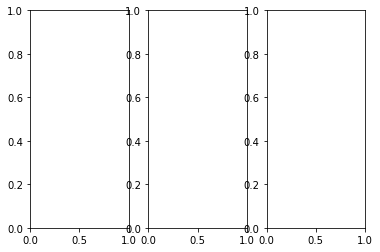

In [61]:
import matplotlib.pyplot as plt

# this creates a 1x3 matrix of plots, and returns a list of axes objects
fig, axes = plt.subplots(1, 3)

# we can now access each axis as axes[0], axes[1], etc.
# or even loop through them as with any other list

In [ ]:
fig, axes = plt.subplots(1, 3)

# enumerate returns a counter as well as the element of the list
for ii, place in enumerate(sentiments.keys()):
    sns.histplot(sentiment, ax=axes[ii])
    axes[ii].set_title('Sentiments for {}'.format(place))